In [35]:
%load_ext lab_black

In [ ]:
# !conda install -n propulsion pyarrow -y

In [4]:
import pandas as pd

In [7]:
df_finances = pd.read_csv("../data/processed/mevluet_data_merged.csv")

In [6]:
# Collected using the Yahoo Finance API
df_prices = pd.read_parquet('../data/raw/stock_closes.pq')

In [8]:
df_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11543 entries, 1990-01-02 to 2021-08-09
Columns: 7073 entries, A to YFI-USD
dtypes: float32(7073)
memory usage: 311.5 MB


In [9]:
df_finances.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19794 entries, 0 to 19793
Data columns (total 88 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Unnamed: 0                                       19794 non-null  int64  
 1   Ticker                                           19794 non-null  object 
 2   SimFinId_x                                       19794 non-null  int64  
 3   Currency_x                                       19794 non-null  object 
 4   Fiscal Year                                      19794 non-null  int64  
 5   Fiscal Period_x                                  19794 non-null  object 
 6   Report Date_x                                    19794 non-null  object 
 7   Publish Date_x                                   19794 non-null  object 
 8   Restated Date_x                                  19794 non-null  object 
 9   Shares (Basic)_x            

In [29]:
df_finances_2005 = df_finances[df_finances['Fiscal Year'] == 2006]

In [42]:
# get price data for 2005 companies in financial dataset

tickers_2005 = set(df_finances_2005["Ticker"])

tickers_prices = set(df_prices.columns)

In [45]:
# check if tickers matches between two datasets

tickers_2005 - tickers_prices
# CGRN not in the price dataset

tickers_2005 = tickers_2005 - {"CGRN"}

In [52]:
prices_2005 = df_prices.loc[:, tickers_2005]
prices_2005 = prices_2005["2005-01-01":"2011-12-31"]
prices_2005.shape

(2556, 56)

In [60]:
# scale to the price on 2005-01-01

prices_2005_scaled = prices_2005 / prices_2005.iloc[0]

<AxesSubplot:xlabel='Date'>

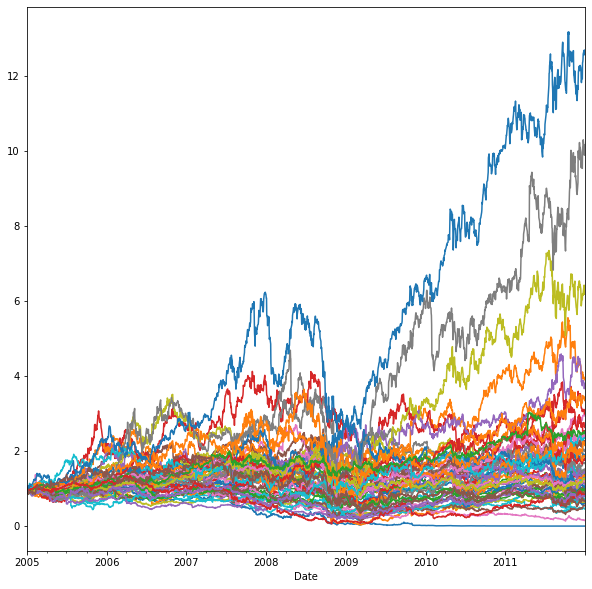

In [64]:
prices_2005_scaled.plot(figsize=(10, 10), legend=False)